# <p><center style="font-family:newtimeroman;font-size:180%;">Alzheimers  ADNI Detection </center></p>
### Table of contents:

* [Import Libraries](#1)
* [Read Data](#2)
* [Visualization Of Dataset](#3)
* [Data Augmentation](#4)
* [VGG16 Model](#10)
* [Evaluate The Model](#11)


**<a id="1"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Import Libraries </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

2024-08-15 12:42:27.169643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 12:42:27.169737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 12:42:27.430977: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**<a id="2"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Read Data </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [2]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/kaggle/input/kmeans-nonsegm')):
    subfolder_path = os.path.join('/kaggle/input/kmeans-nonsegm', subfolder)
    for folder in os.listdir(subfolder_path):
        # subfolder_path2=os.path.join(subfolder_path,folder)
        # for image_filename in os.listdir(subfolder_path2):
        image_path = os.path.join(subfolder_path, folder)
        images.append(image_path)
        labels.append(subfolder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


,image,label
0,/kaggle/input/kmeans-nonsegm/MCI/I20004_slice_...,MCI
1,/kaggle/input/kmeans-nonsegm/MCI/I46884_slice_...,MCI
2,/kaggle/input/kmeans-nonsegm/MCI/I137797_slice...,MCI
3,/kaggle/input/kmeans-nonsegm/MCI/I263034_slice...,MCI
4,/kaggle/input/kmeans-nonsegm/MCI/I56913_slice_...,MCI
...,...,...
15326,/kaggle/input/kmeans-nonsegm/CN/I399701_slice_...,CN
15327,/kaggle/input/kmeans-nonsegm/CN/I476648_slice_...,CN
15328,/kaggle/input/kmeans-nonsegm/CN/I157178_slice_...,CN
15329,/kaggle/input/kmeans-nonsegm/CN/I71098_slice_0...,CN


In [3]:
df1=df[(df['label']=='CN') | (df['label']=='MCI') ]
df = df1

In [5]:
import pandas as pd


print(df['label'].value_counts())

# Trouver la taille de la plus petite classe
min_class_size = df['label'].value_counts().min()

# Échantillonner chaque classe pour obtenir le même nombre d'images
df_balanced = df.groupby('label').apply(lambda x: x.sample(min_class_size)).reset_index(drop=True)

# Afficher la distribution finale des étiquettes
print(df_balanced['label'].value_counts())


label
CN     5076
MCI    5023
Name: count, dtype: int64
label
CN     5023
MCI    5023
Name: count, dtype: int64


/tmp/ipykernel_35/2449948185.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('label').apply(lambda x: x.sample(min_class_size)).reset_index(drop=True)


In [8]:
df=df_balanced

**<a id="3"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Visualization of Dataset </p>
<a class="btn" href="#home">Tabel of Contents</a>

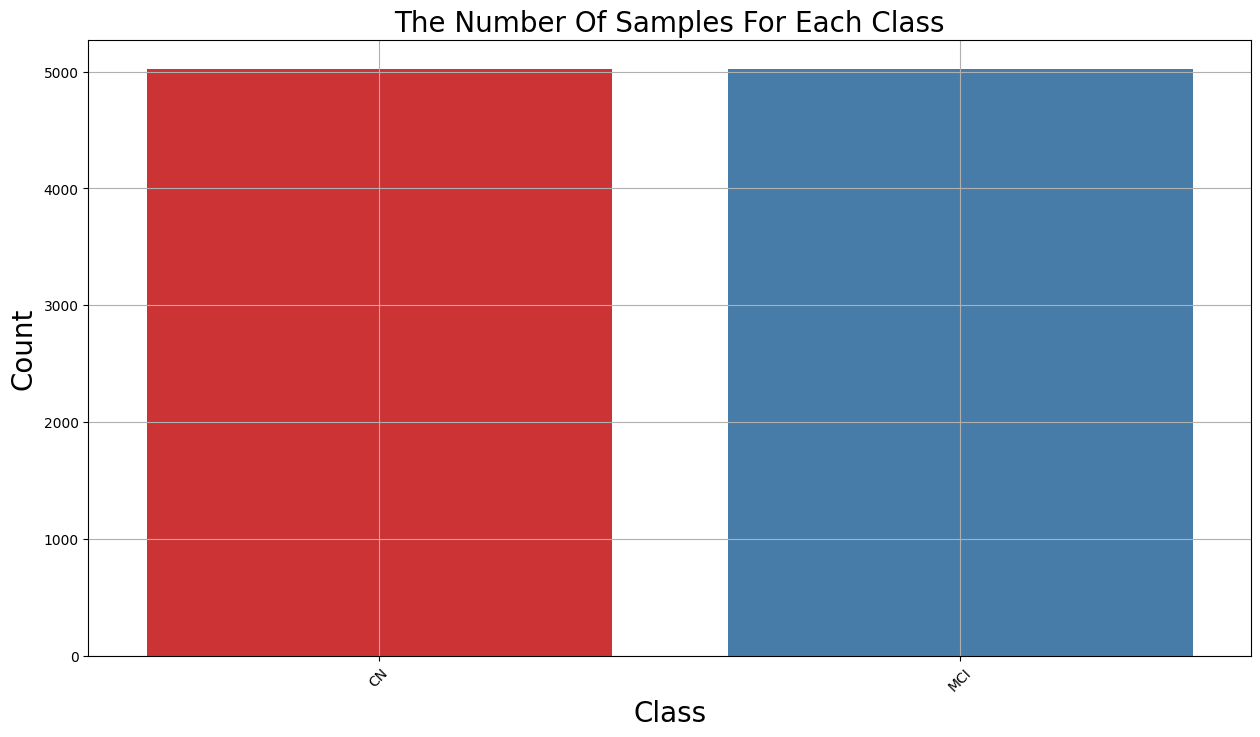

In [9]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

<a id="4"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Data Augmentation </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [10]:
X_train, X_test1, y_train, y_test1 = train_test_split(df['image'], df['label'], test_size=0.2, random_state=42,shuffle=True,stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

In [11]:
image_size = (224,224)
batch_size = 32
datagen = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.resnet.preprocess_input,
#     rescale=1./255
#     horizontal_flip=True,
#     rotation_range=10,        # Utiliser une petite plage de rotation
#     width_shift_range=0.1,    # Décalage horizontal modéré
#     height_shift_range=0.1,   # Décalage vertical modéré
#     # shear_range=0.1,          # Cisaillement modéré
#     zoom_range=0.1,           # Zoom modéré
#     # brightness_range=[0.8, 1.2], # Variation de luminosité
#     fill_mode='nearest'       # Méthode de remplissage des pixels générés
)
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 8036 validated image filenames belonging to 2 classes.
Found 1005 validated image filenames belonging to 2 classes.
Found 1005 validated image filenames belonging to 2 classes.


In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)
batch_size = 32

# Création du générateur de données sans prétraitement complexe
datagen = ImageDataGenerator(
    rescale=1./255  # Normalisation des valeurs des pixels entre 0 et 1
)

# Générateur pour l'entraînement
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Générateur pour le test
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Générateur pour la validation
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


Found 8121 validated image filenames belonging to 2 classes.
Found 1016 validated image filenames belonging to 2 classes.
Found 1015 validated image filenames belonging to 2 classes.


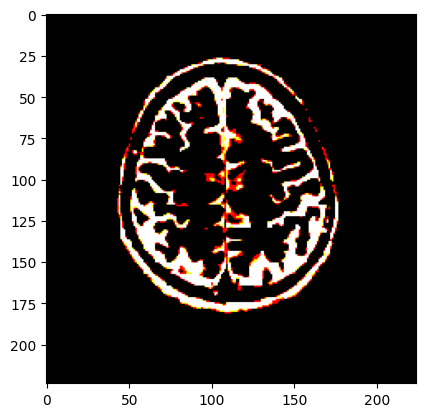

In [12]:
import matplotlib.pyplot as plt

# Obtenir une image du générateur
sample_image, _ = next(train_generator)

# Afficher l'image
plt.imshow(sample_image[5])
plt.show()


In [13]:
class_num=list(train_generator.class_indices.keys())
class_num

['CN', 'MCI']

In [ ]:
from tensorflow.keras import layers, models

# Initialiser le modèle séquentiel
model = models.Sequential()

# Convolution Layer 1
model.add(layers.Conv2D(32, (4, 4), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.Dropout(0.2))
model.add(layers.ZeroPadding2D(padding=(3, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution Layer 2
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.ZeroPadding2D(padding=(2, 2)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution Layer 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.ZeroPadding2D(padding=(1, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution Layer 4
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.ZeroPadding2D(padding=(1, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution Layer 5
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.ZeroPadding2D(padding=(1, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten pour passer aux couches entièrement connectées
model.add(layers.Flatten())

# Fully Connected Layers
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))

# Ajouter la couche de sortie pour la classification (par exemple, softmax pour 3 classes)
model.add(layers.Dense(2, activation='softmax'))

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()


In [ ]:
checkpoint_cb =ModelCheckpoint("model_VGG16.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=15, restore_best_weights=True)
# model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_generator, epochs=200, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])

<a id="10"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">VGG16 Modeling </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [14]:
model = keras.models.Sequential()
model.add(tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, pooling='avg', weights='imagenet'))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2048, activation='relu'))
# model.add(keras.layers.Dropout(0.5))  # Ajout de dropout après la première couche dense
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1024, activation='relu'))
# model.add(keras.layers.Dropout(0.5))  # Ajout de dropout après la deuxième couche dense
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2, activation='softmax'))
model.layers[0].trainable = False
model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 2048)              1050624   
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                         

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense, Input
from tensorflow.keras.models import Model

# Charger le modèle VGG16 avec les poids pré-entraînés d'ImageNet
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, pooling='avg', weights='imagenet')

# Créez un modèle fonctionnel
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # Assurez-vous que base_model ne soit pas en mode entraînement
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(2048, activation='relu')(x)
# x = Dropout(0.5)(x)  # Ajouter Dropout si nécessaire
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)  # Ajouter Dropout si nécessaire
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs, outputs)

# Geler les poids du modèle VGG16 pré-entrainé
base_model.trainable = False

model.summary()


In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Checkpoint pour sauvegarder les meilleurs poids
checkpoint_cb = ModelCheckpoint("model_VGG16.h5", save_best_only=True)

# Early stopping pour éviter le surapprentissage
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# Scheduler pour réduire le taux d'apprentissage en cas de stagnation
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Compiler le modèle avec l'optimiseur Adam
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle avec les callbacks ajustés
hist = model.fit(train_generator, epochs=200, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb])


In [ ]:
from tensorflow.keras.optimizers import SGD
# Using SGD optimizer with lower learning rate and momentum
optimizer = SGD(learning_rate=0.001, momentum=0.9)

checkpoint_cb = ModelCheckpoint("model_VGG16.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=15, restore_best_weights=True)  # Increase patience

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
hist = model.fit(train_generator, epochs=200, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])

In [15]:
checkpoint_cb =ModelCheckpoint("model_VGG16.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=15, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_generator, epochs=200, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/200


I0000 00:00:1723725956.546089     121 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


252/252 [==============================] - ETA: 0s - loss: 0.6778 - accuracy: 0.7494

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


252/252 [==============================] - 126s 439ms/step - loss: 0.6778 - accuracy: 0.7494 - val_loss: 0.4072 - val_accuracy: 0.8159
Epoch 2/200
252/252 [==============================] - 39s 155ms/step - loss: 0.3419 - accuracy: 0.8611 - val_loss: 0.2792 - val_accuracy: 0.8866
Epoch 3/200
252/252 [==============================] - 37s 147ms/step - loss: 0.2571 - accuracy: 0.8982 - val_loss: 0.2789 - val_accuracy: 0.8925
Epoch 4/200
252/252 [==============================] - 39s 152ms/step - loss: 0.1885 - accuracy: 0.9286 - val_loss: 0.2564 - val_accuracy: 0.9164
Epoch 5/200
252/252 [==============================] - 37s 145ms/step - loss: 0.1501 - accuracy: 0.9393 - val_loss: 0.2447 - val_accuracy: 0.9174
Epoch 6/200
252/252 [==============================] - 37s 146ms/step - loss: 0.1131 - accuracy: 0.9577 - val_loss: 0.2355 - val_accuracy: 0.9234
Epoch 7/200
252/252 [==============================] - 38s 151ms/step - loss: 0.1038 - accuracy: 0.9620 - val_loss: 0.2902 - val_accura

<a id="11"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Evaluate The Model  </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [16]:
model.save('/kaggle/working/modele_checkpoint.h5')
print("Le modèle a été sauvegardé sous le nom 'mon_modele.h5'")

Le modèle a été sauvegardé sous le nom 'mon_modele.h5'


In [17]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.677799,0.749378,0.407189,0.815920
1,0.341911,0.861125,0.279180,0.886567
2,0.257131,0.898208,0.278877,0.892537
3,0.188478,0.928571,0.256418,0.916418
4,0.150146,0.939273,0.244700,0.917413
5,0.113060,0.957690,0.235505,0.923383
6,0.103776,0.962046,0.290239,0.912438
7,0.124585,0.952464,0.228538,0.924378
8,0.089062,0.966277,0.192098,0.939303
9,0.103870,0.961548,0.216697,0.931343


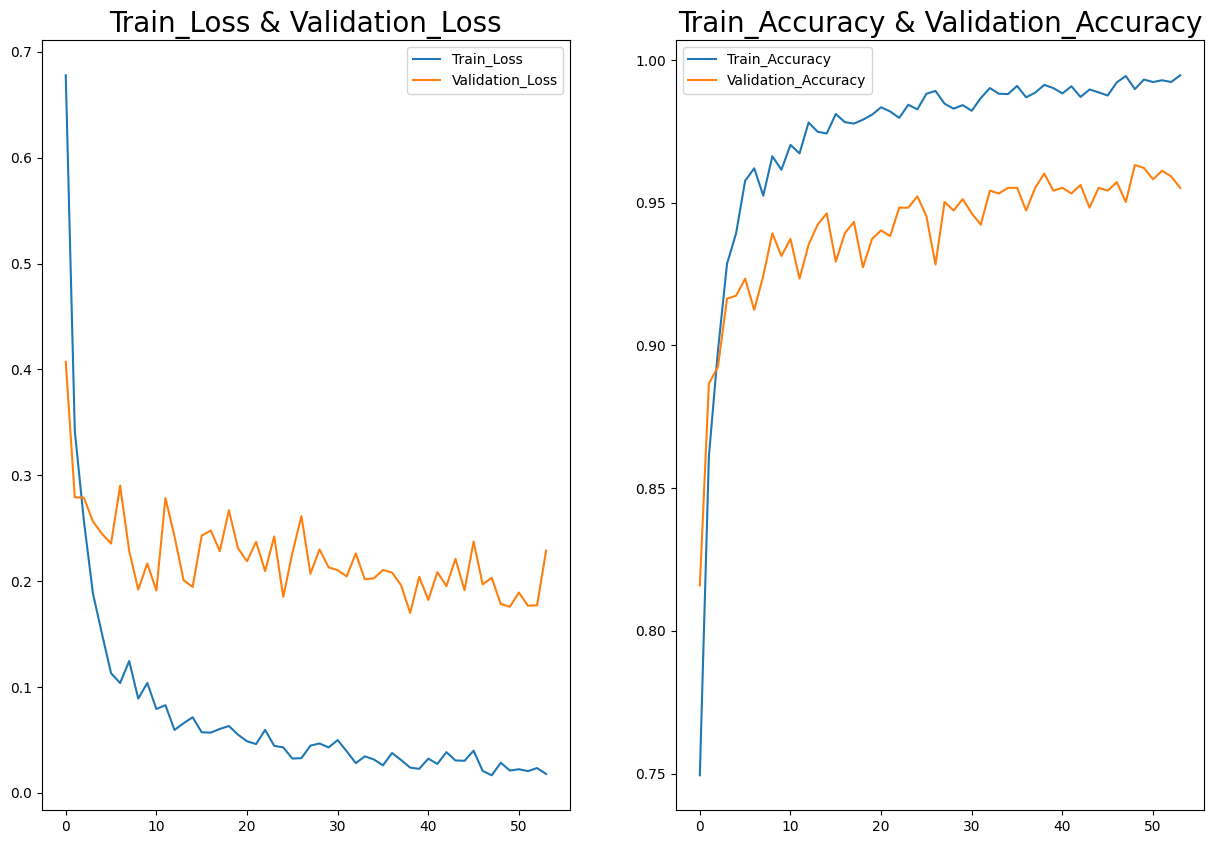

In [18]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [19]:
score, acc= model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)

32/32 [==============================] - 12s 375ms/step - loss: 0.1274 - accuracy: 0.9701
Test Loss = 0.1274402141571045
Test Accuracy = 0.9701492786407471


In [20]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

32/32 [==============================] - 4s 124ms/step


,Actual,Prediction
0,1,1
1,1,1
2,0,0
3,0,0
4,1,1
...,...,...
1000,1,1
1001,1,1
1002,0,0
1003,1,1


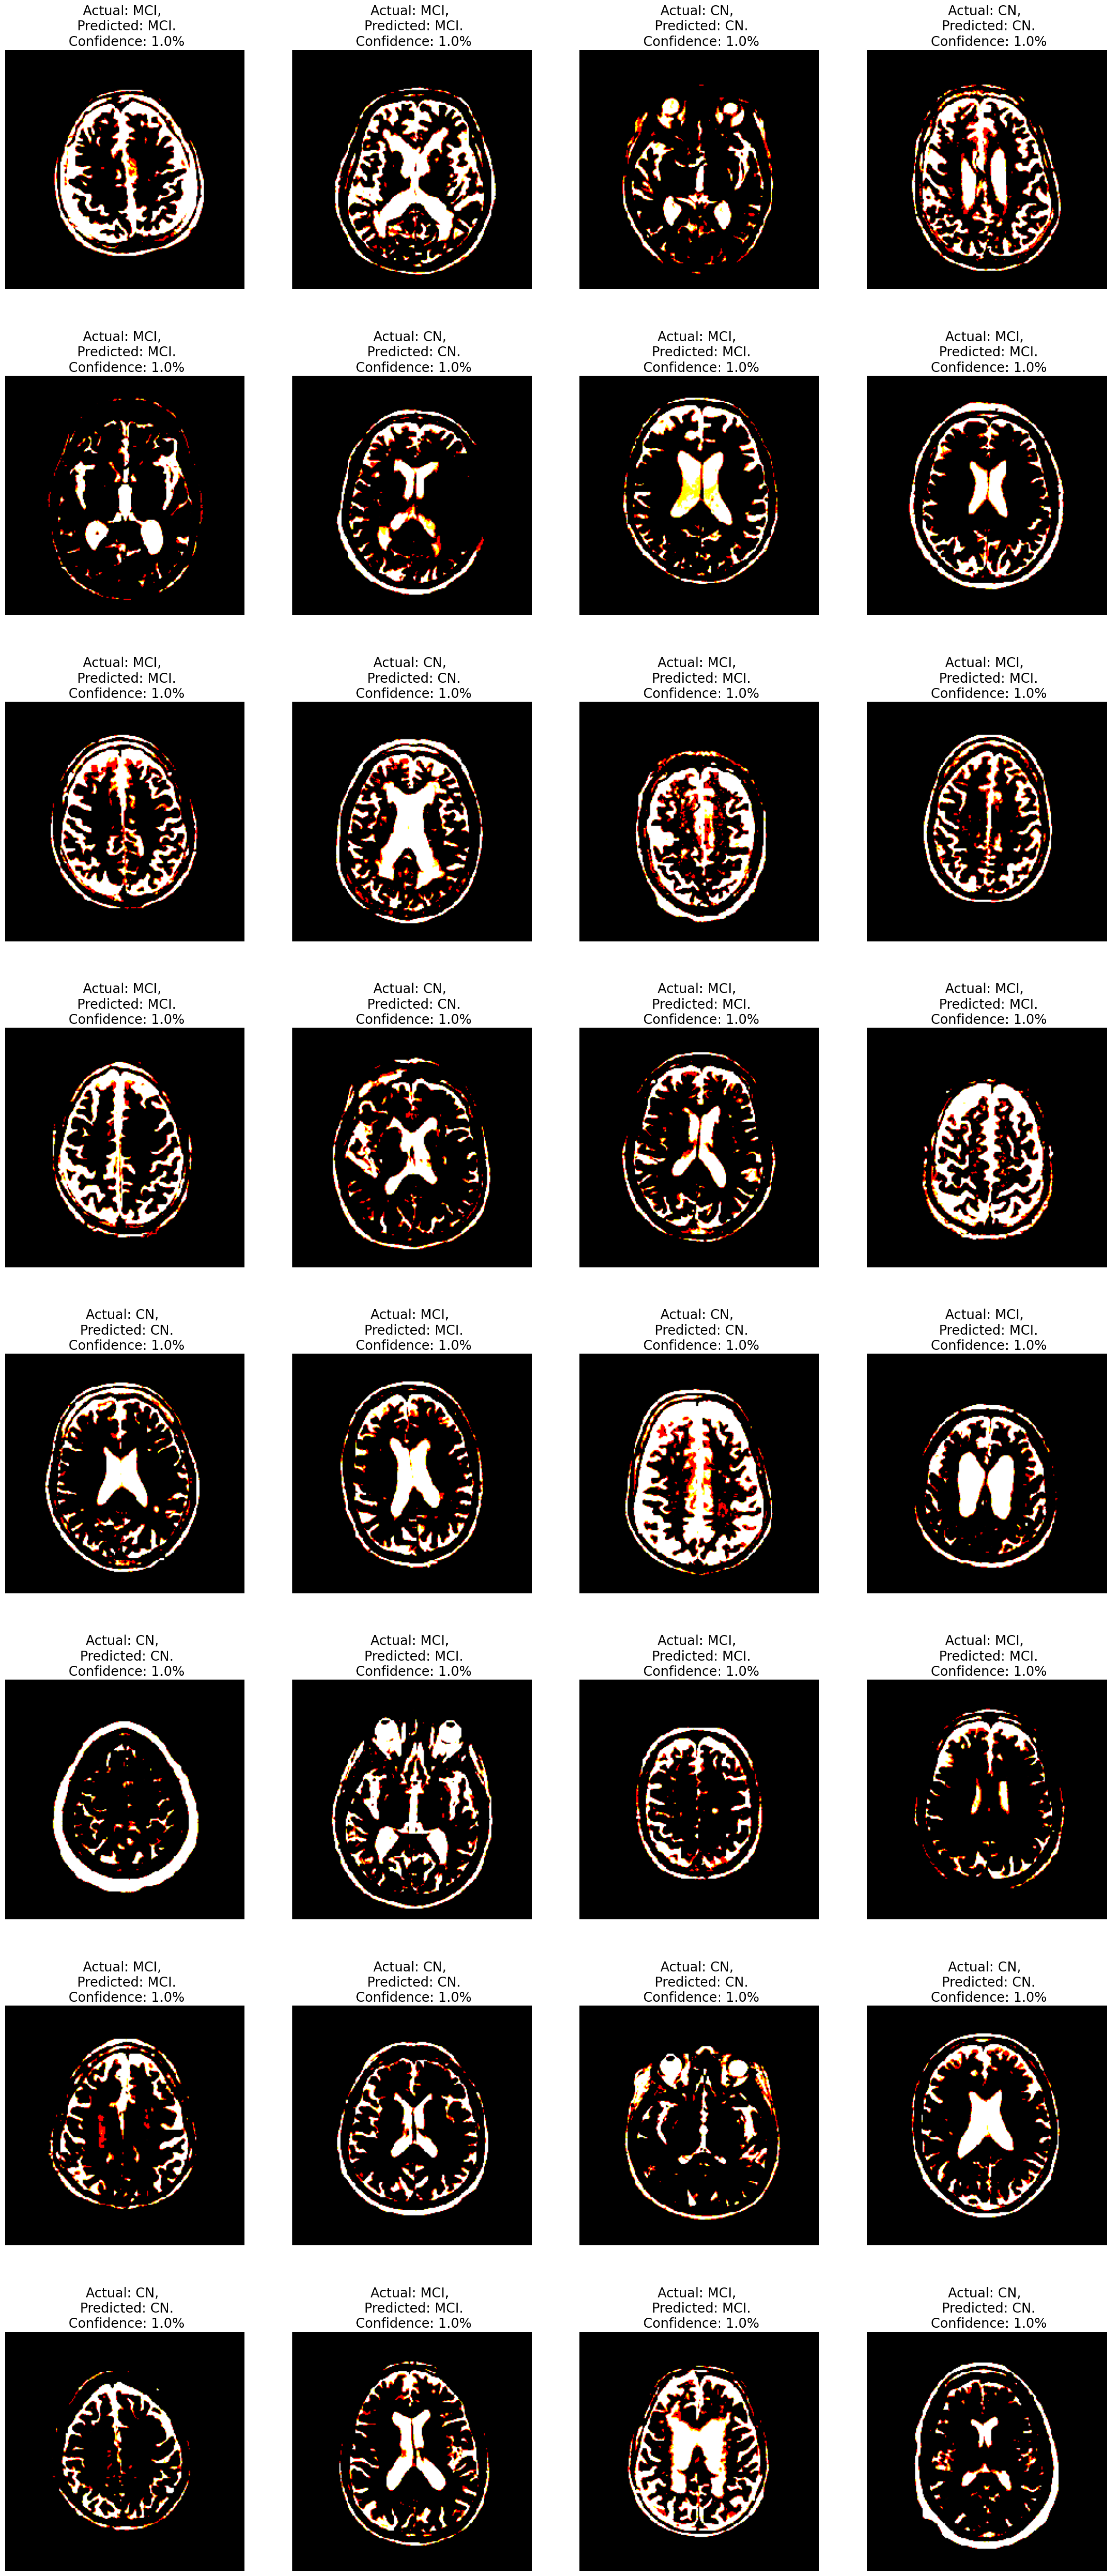

In [21]:
plt.figure(figsize=(30,70))
batch = next(test_generator)
images= batch[0]
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(f"Actual: {class_num[y_test[n]]}, \n Predicted: {class_num[y_pred[n]]}.\n Confidence: {round(predictions[n][np.argmax(predictions[n])],0)}%",fontsize=20)

array([[490,  13],
       [ 17, 485]])

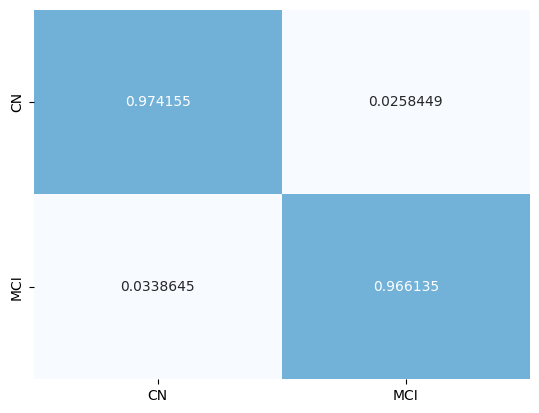

In [22]:
CM = confusion_matrix(y_test,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues',xticklabels=class_num, yticklabels=class_num)
CM

In [23]:
ClassificationReport = classification_report(y_test,y_pred,target_names=class_num)
print('Classification Report is : ', ClassificationReport)

Classification Report is :                precision    recall  f1-score   support

          CN       0.97      0.97      0.97       503
         MCI       0.97      0.97      0.97       502

    accuracy                           0.97      1005
   macro avg       0.97      0.97      0.97      1005
weighted avg       0.97      0.97      0.97      1005

